In [118]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import random

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import ggplot as R

from functools import reduce
import operator

import jieba.analyse
import jieba
from opencc import OpenCC #繁簡轉換


In [119]:
dirPath = 'C:/Users/danie/OneDrive/桌面/project data/'
print(os.listdir(dirPath),'\n')
result = [os.listdir(os.path.join(dirPath, f)+'/') for f in os.listdir(dirPath)]
print(result)

['中信', '國泰', '富邦', '玉山'] 

[['i繳費(google).csv', 'i繳費.csv', '中信亮點(google).csv', '中信亮點.csv', '中信卡優惠(google).csv', '中信卡優惠.csv', '中信服務讚(google).csv', '中信服務讚.csv', '中信行動企業家(google).csv', '中信行動企業家.csv', '中信行動刷卡(google).csv', '中信行動刷卡.csv', '中國信託行動銀行(google).csv', '中國信託行動銀行.csv', '中國信託證券-點富王(google).csv', '中國信託證券-點富王.csv', '台灣人壽(google).csv', '台灣人壽.csv'], ['KOKO(google).csv', 'KOKO.csv', '國泰世華 行動銀行(google).csv', '國泰世華 行動銀行.csv', '國泰人壽(google).csv', '國泰人壽.csv', '國泰優惠(google).csv', '國泰優惠.csv', '國泰證券 e櫃台(google).csv', '國泰證券 e櫃台.csv', '國泰證券 樹精靈(google).csv', '國泰證券 樹精靈.csv', '國泰證券「線上開戶」(google).csv', '國泰證券「線上開戶」.csv', '國泰證券「隨身證券」(google).csv', '國泰證券「隨身證券」.csv', '股票快選(google).csv', '股票快選.csv', '股票抽籤(google).csv', '股票抽籤.csv'], ['富邦e+(google).csv', '富邦e+.csv', '富邦投信(google).csv', '富邦投信.csv', '富邦期貨(google).csv', '富邦產險(google).csv', '富邦產險.csv', '富邦行動商務(google).csv', '富邦行動商務.csv', '富邦行動銀行(google).csv', '富邦行動銀行.csv', '富邦證券 e開戶(google).csv', '富邦證券 e開戶.csv', '富邦證券 e點通(google).csv', '富邦證券 e點通.csv', '手機e方便(go

In [120]:
list_of_df=[]
for i in range(4):
    
    company = os.listdir(dirPath)[i]
    
    for data in result[i]:
        df = pd.read_csv(dirPath+company+'/'+data)
        if 'google' in data:
            df = df.drop(['likecounts'], axis=1)
            df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, "%Y年%m月%d日").strftime('%Y/%m/%d'))
        else:
            df['Content'] = df['Title']+df['Content']
            df = df.drop(['Title'], axis=1)
            df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x.split('T')[0], "%Y-%m-%d").strftime('%Y/%m/%d'))
        
        df.loc[:,'company'] = company
        df.loc[:,'product'] = data
    
        list_of_df.append(df)

In [121]:
raw_data = pd.concat(list_of_df, ignore_index=True)
raw_data = raw_data[~raw_data['Content'].isna()].reset_index(drop=True)

In [122]:
bar_df = pd.DataFrame(raw_data.groupby(['Star', 'company']).size()).reset_index()
bar_df = bar_df.rename(columns={0:'counts'})
bar_df.head()

,Star,company,counts
0,1,中信,12829
1,1,國泰,8746
2,1,富邦,4340
3,1,玉山,5488
4,2,中信,2250


In [130]:
x1 = bar_df.loc[bar_df.company=='國泰','Star']
y1 = bar_df.loc[bar_df.company=='國泰','counts']

x2 = bar_df.loc[bar_df.company=='中信','Star']
y2 = bar_df.loc[bar_df.company=='中信','counts']

x3 = bar_df.loc[bar_df.company=='玉山','Star']
y3 = bar_df.loc[bar_df.company=='玉山','counts']

x4 = bar_df.loc[bar_df.company=='富邦','Star']
y4 = bar_df.loc[bar_df.company=='富邦','counts']

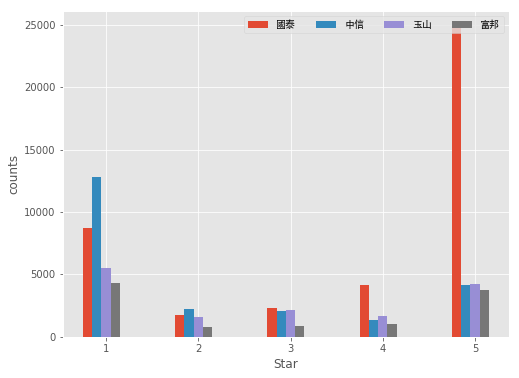

In [142]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')
myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\SimHei.ttf')

w=0.1
plt.bar(x1-0.2, y1,width=w , align='center', label='國泰')
plt.bar(x2-0.1, y2, width=w ,align='center', label='中信')
plt.bar(x3, y3,width=w , align='center', label='玉山')
plt.bar(x4+0.1, y4, width=w ,align='center', label='富邦')

plt.xlabel('Star')
plt.ylabel('counts')

plt.legend(prop=myfont, loc="upper right", ncol=4)

In [132]:
raw_data.loc[:,'Content_len'] = raw_data['Content'].apply(lambda x: len(x))
raw_data['dev_content'] = raw_data['dev_content'].apply(lambda x: str(x))

In [133]:
raw_data.loc[(raw_data['dev_content']==' ')|(raw_data['dev_content']=='nan'), 'dev_content']=''

In [134]:
raw_data['reply'] = (raw_data['dev_content'].apply(lambda x: len(x))>0).astype(int)

In [135]:
raw_data.groupby(['company'])['reply'].sum()/raw_data.groupby(['company'])['company'].size()

company
中信    0.786382
國泰    0.321236
富邦    0.753646
玉山    0.840013
dtype: float64

In [136]:
raw_data = raw_data[raw_data['Content_len']>5].reset_index(drop=True)
raw_data['Y_m'] = raw_data['Time'].apply(lambda x: x[:7])
raw_data['product'] = raw_data.loc[:,'product'].apply(lambda x: x.split('.csv')[0])

### 聲量分析

In [137]:
raw_data['product'] = raw_data['product'].apply(lambda x: x.split('(')[0])

In [138]:
vol_df = pd.DataFrame({'vol':raw_data.groupby(['product']).size(), 'Star':raw_data.groupby(['product'])['Star'].mean(), 'c':pd.DataFrame(raw_data.groupby(['product','company'], as_index=False).size()).reset_index()['company'].values}).reset_index()

In [139]:
vol_df['color'] = vol_df['c'].map({'國泰':'Green', '玉山':'Red', '中國信託':'Blue', '富邦':'Orange'})

In [140]:
vol_df['c'] = vol_df['c'].map({'國泰':'cathay', '玉山':'esun', '中國信託':'ctbc', '富邦':'fubon'})

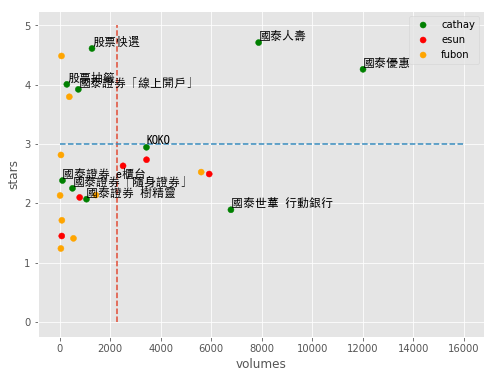

In [141]:
plt.style.use('ggplot')
myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\SimHei.ttf')

plt.figure(figsize=(8,6))

for df in vol_df.groupby(['c']):
    temp = df[1]
    label = df[0]
    plt.scatter(temp['vol'], temp['Star'], c=temp['color'], label=label)
    if label=='cathay':
        for name, x ,y in zip(df[1]['product'], df[1]['vol'], df[1]['Star']):
            plt.annotate(name, xy=(x,y), xytext = (x+0.1, y+0.05), fontproperties=myfont, size=12)
            
plt.xlabel('volumes')
plt.ylabel('stars')
plt.legend()
    
plt.plot( [vol_df['vol'].mean(),vol_df['vol'].mean()], [0,5],'--')
plt.plot( [0,16000], [3,3],'--')

In [143]:
dirPath = 'C:/Users/danie/OneDrive/桌面/Update/'
result = [f for f in os.listdir(dirPath)]
print(result)

['KOKO.csv', '國泰世華 行動銀行.csv', '國泰人壽.csv', '國泰優惠.csv', '國泰證券 e櫃台.csv', '國泰證券 樹精靈.csv', '國泰證券「線上開戶」.csv', '國泰證券「隨身證券」.csv', '股票快選.csv', '股票抽籤.csv']


In [144]:
df = pd.DataFrame()
for p in result:
    temp = pd.read_csv(dirPath+p)
    temp['Product'] = p[:-4]
    df = pd.concat([df, temp], axis=0)

df = df.reset_index(drop = True)

df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%Y年%m月%d日").strftime('%Y/%m/%d'))

products = df['Product'].unique()

KOKO
2020/06/18
['更新', '資料', '無法', '系統', '登入', '什麼']
['爛到不行，為了更新個人資料，無法登錄網銀(而且是某一天突然變更，前幾天還可以用)，也不提供方法，找半天，以後不想用了，指紋登錄也廢止，真的很爛', '驗證系統有很嚴重問題。忘記密碼的第一步驟，明明輸入都正確系統卻無法接受。記得當初剛安裝也是，身分證和生日輸入正確，系統卻說有問題，奇怪，我是第一次申請耶？！', '更新又重灌，系統還是慢到哭巴，怎麼回事，修理一下好嗎？']




<Figure size 432x288 with 0 Axes>

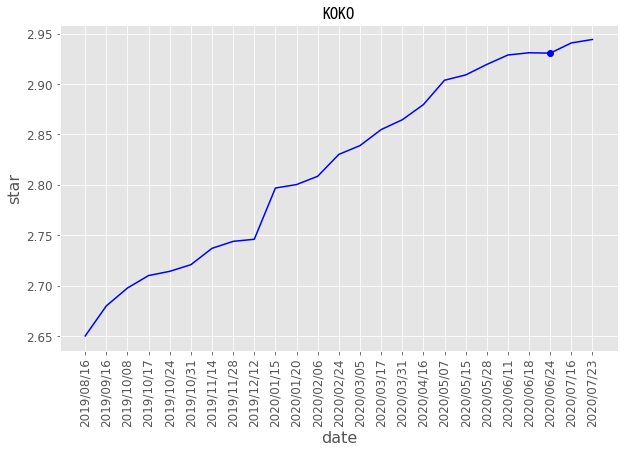

國泰世華 行動銀行
2019/09/20
['轉帳', '無法', '更新', 'app', '登入', '一直']
['轉帳修不好是怎樣寄email給你們董事長申訴', '爛更新後到現在一直卡住 害我這禮拜一直跑ATM匯款，造成了非常大的困擾', '爛網路銀行爛透了，系統一直出錯，匯個錢都沒辦法']
2019/11/06
['密碼', '登入', '銀行', '轉帳', 'app', '設定']
['愈改愈糟糕 消費訊息竟然在一個多小時後才通知 萬一被盜刷…人都跑了', '設計不良常常要重新設置帳號密碼，改到我自己都記不起來 很麻煩欸', '帳戶餘額突然變0整個傻眼 查網路銀行明明就還有錢']
2020/06/08
['登入', '更新', '無法', '開此', 'app', '難用']
['難用可以更改一下嗎難用', '不知道在爛甚麼快點改進品質', '壞了完全壞了那天去銀行，連銀行刷簿子、交易都掛了，還要什麼圖？問問行員吧！']




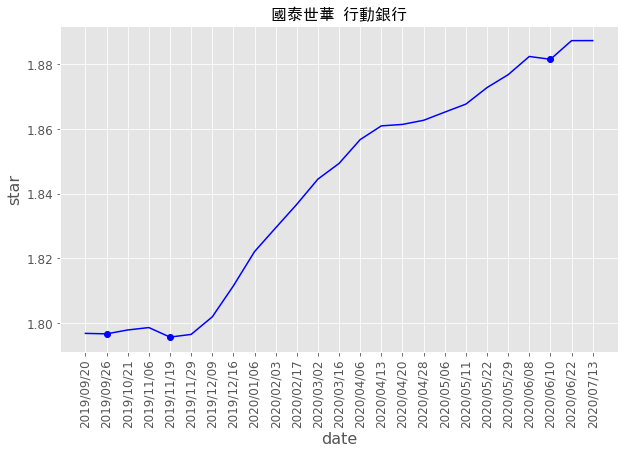

國泰人壽
2018/08/27
['電話', 'app', '時間', '無法', '計步', '國泰人壽']
['今天要登入更新步數 忽然顯示一堆亂碼 最上面寫格式錯誤 請問怎麼回事', '超難用密碼已經都快忘記了還要六個月換一次，吃飽閒著嗎？', '我更新fit後就無法計步了，所以國泰人壽app一直顯示0，但是用Samsung health卻還是可以計步，問題到底出在哪，浪費我好多時間~~']
2018/09/02
['app', '簽收', '網站', '錯誤', '這麼', '計步']
['明明是電子化服務，但卻比紙筆簽收還要麻煩，電子簽收網站還是錯誤的，還不能用Google找網站，只能用chrome，可以改進嗎？浪費時間，敗壞國泰名譽', '剛打開就格式錯誤是怎？🙄', '剛打開就格式錯誤是怎？🙄']
2018/09/13
['APP', '這麼', '手機', '更新', '結果', '顯示']
['走路騙人步數根本異常啊，更新也不即時，和健康的數據完全不一樣，上週已經達標也沒送獎勵，這週已經達標四天被強制APP更新，結果變成達標0天，送禮券送的這麼不甘願喔，APP更新驗收改數據的啦？', '完全登不進去網路正常就是 怎麼登就是進不去', '我爸的手機先前還好好的，計步器也是好的，結果國泰人壽APP要更新就出問題了，一直顯示要重新登入google帳號，明明已經再登入還是不行，別的APP下載都很順利，就國泰世華無法下載，先前連續這麼多天超過7500步都白費了，其他手機都不會，然後另一支手機fit是新版的，根本計步都跑不動，只能說這個活動很沒誠意，浪費這麼多時間，最後什麼都拿不到']
2018/09/20
['同步', '資料', '問題', '無法', 'app', '時間']
['指紋辯識有問題更新後，指紋辯識就一直有問題，解鎖自己手機都沒問題', '指紋辯識有問題更新後，指紋辯識就一直有問題，解鎖自己手機都沒問題', '早上用還好好 晚上看 app 出現一些亂碼 走路天數快到了 浪費我時間']
2019/04/02
['更新', '無法', '強制', '結果', '保單', '畫面']
['無法更新資料想更新資料，結果email驗證碼在手機上根本點不到輸入格', '更新後無法使用,客服踢足球.三星兩支手機都一样不能.移除重灌也一樣', '強制更新後畫

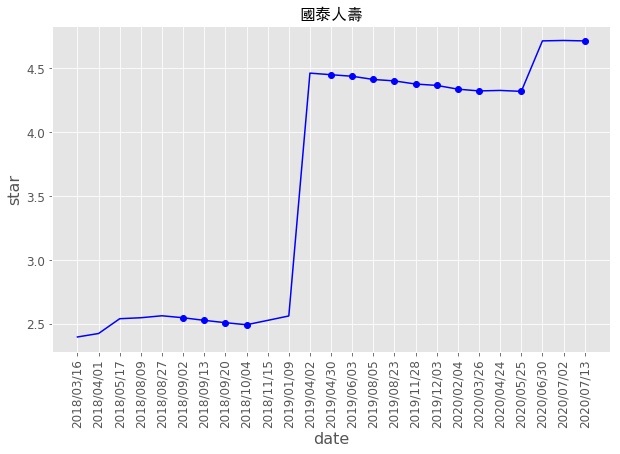

國泰優惠
2019/01/24
['無法', 'app', '登入', '更新', '開啟', '打不開']
['哇~我的狀況跟最近一些人的反映一樣，無法進入開不了，真奇怪！', '為什麼會員登不療', '都沒什麼優惠，只好刪除app了']
2019/03/11
['兌換', '系統', '無法', '更新', '處理', '輸入']
['沒有刷卡消費明細項目可以查詢', '50元兌券 中杯美式 3/31道期 不能使用APP兌換 到全家輸入14位pin碼又顯示已兌換 無法列印 請相關人員協助處理', '一直在更新已經一個禮拜從早上到晚上打開來看都寫系統更新，錯誤（310）']
2019/04/02
['無法', '登入', '活動', '系統', 'app', '顯示']
['server回應速度太慢', '登入速度很慢，系統也常常出問題', 'server回應速度太慢']
2019/06/04
['app', '無法', '更新', '什麼', '登入', '問題']
['什麼爛App 什麼身份字號不存在 明明是我的身分 證字號為什麼不能登入', '整天更新不了! 要悅換的東西，無法進去使用! 到底…… 無法更新! 也無法重新下載! 整個沒反應! 不想使用了!', '點數沒辦法一次跟新到位每次要換食品都不知道能換什麼']
2019/07/05
['沒有', '活動', '無法', 'app', '登入', '開啟']
['國泰長榮聯名卡 機票換不到、提早一年還是候補 辦聯名卡有個屁用？', '執行速度好慢，一直在轉圈圈！', '50分就進入App準備搶購人氣活動登入不進去一直系統忙碌中然後閃退最後進去了也是整個卡住很當無法點最後到可以購買網頁 輸入卡號後按準備要結帳卻跳出 慢了一步 商品已搶完那幹嘛還要輸入才來通知 多此一舉給人希望又失望！']
2019/07/23
['無法', '登入', '更新', 'app', '一直', '什麼']
['無法登入奇怪為什麼一堆人反應輸入身分證號碼後無法登入卻又還不改善呢？我已經寄了很多信給你們反應這個狀況了，感覺你們好像一知半解。無言', '不論是開app或點選任何選項都loading很久 尤其是麻吉付 根本打不開', '為何無法換7-11禮卷，吉星星好幾個，點進去無法登入']
2019/08/12
['app', '畫面

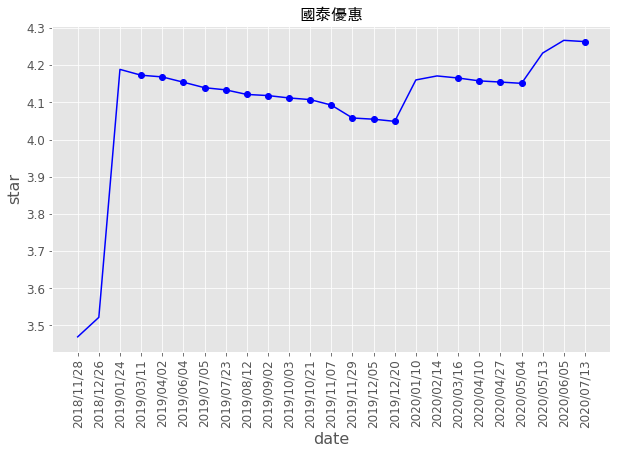

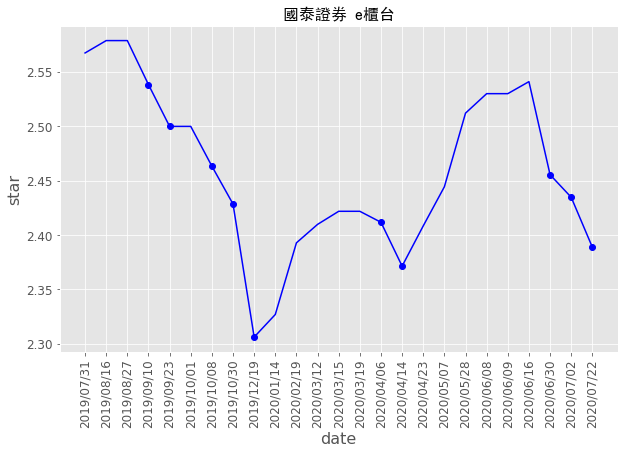

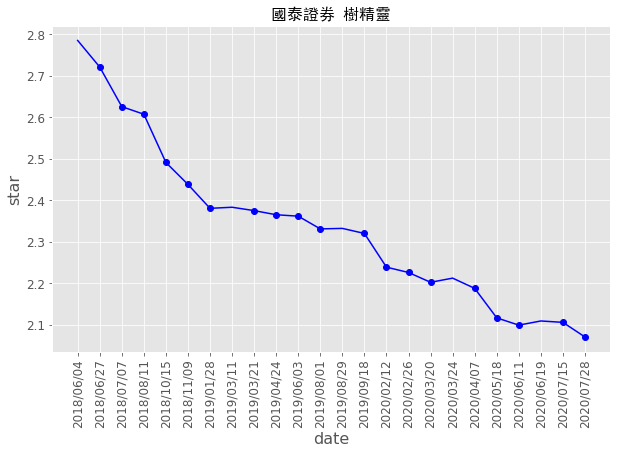

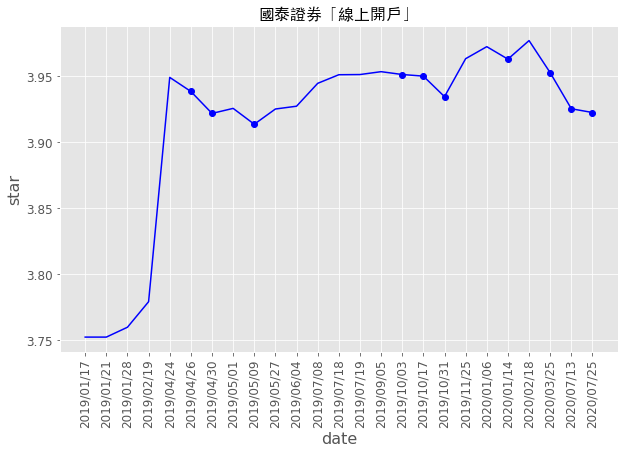

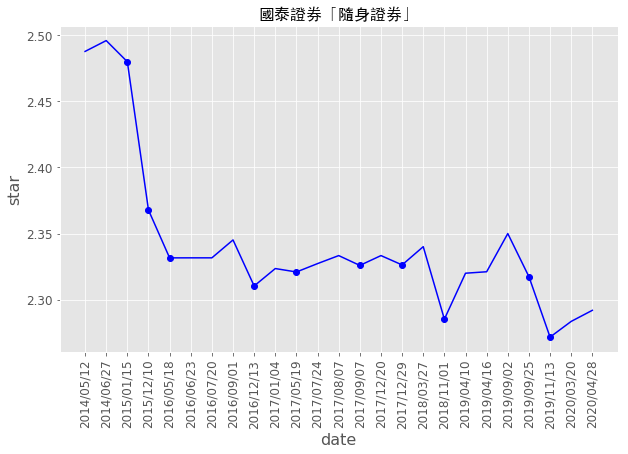

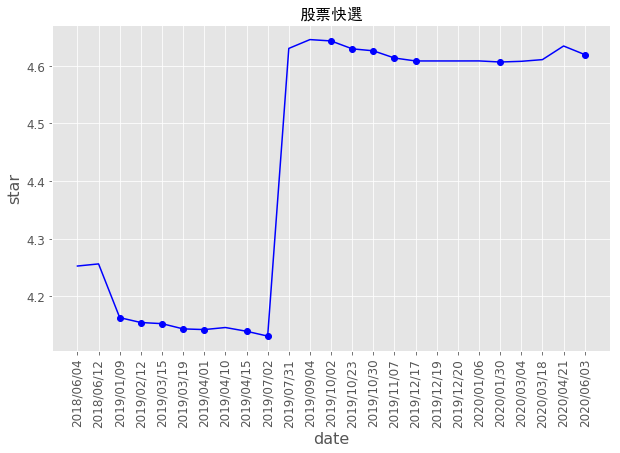

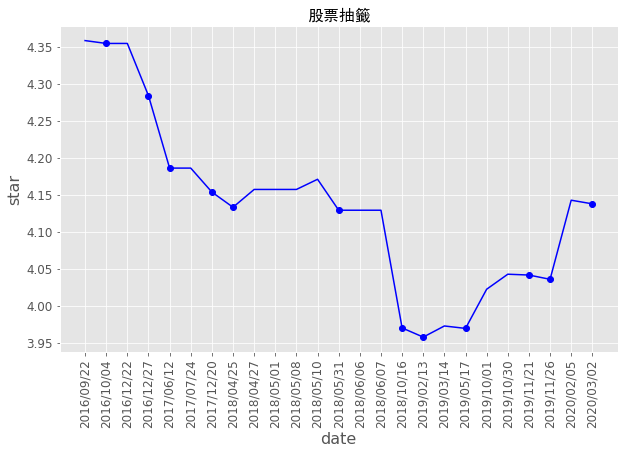

In [155]:
# fig,ax = plt.subplots(5, 2, figsize=(20,30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.5)
myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\SimHei.ttf')

for i in range(len(products)):
    datelist = df[df['Product']==products[i]]['Date']
    datelist = datelist.sort_values().reset_index(drop=True)
    subset = raw_data[raw_data['product'] == df['Product'].unique()[i]]
    update_star = [(subset[subset['Time']<datelist[i]]['Star'].mean(), datelist[i]) for i in range(len(datelist))]
    update_star = pd.DataFrame(update_star)
    update_star.columns = ['star', 'date']
    update_star['label'] = update_star['star'].shift(-1)
    update_star['label'] = (update_star['label']<update_star['star']).values.astype(int)
    update_star['label'] = update_star['label'].shift(1).fillna(0)
    update_star['product'] = products[i]
      
    if i<4:
        comments = []
        print(products[i])
        for date_idx in np.nonzero(update_star['label'].values==1)[0]:
            print(update_star['date'].tolist()[date_idx-1])
            comment = subset[(subset['Time']>=update_star['date'][date_idx-1])&(subset['Time']<update_star['date'][date_idx])&(subset['Star']<3)]['Content'].values
            print(jieba.analyse.extract_tags(reduce(operator.concat, comment.tolist()), topK=6, withWeight=False, allowPOS=()))
            comments.append(comment)
            print(random.choices(comment, k=3))
        print('\n')
    
    markers_on=np.nonzero(update_star['label'].values)[0]
    fig,ax = plt.subplots(1, 1, figsize=(10,6))
#     ax = plt.subplot(5, 2, i+1)
    ax = plt.subplot(1, 1, 1)
    plt.title(products[i],  fontproperties=myfont, size=16)
    plt.plot(update_star['date'], update_star['star'], '-bo', markevery=markers_on.tolist())
    plt.xlabel('date', size=16)
    plt.ylabel('star', size=16)
    plt.xticks(rotation=90, size=12)
    plt.yticks(size=12)

    plt.show()


In [ ]:
cc = OpenCC('t2s')

raw_data['Content'] = raw_data['Content'].apply(lambda x: cc.convert(x))

In [ ]:
jieba.suggest_freq( '信用卡费', True)
jieba.suggest_freq( '上一次', True)
jieba.suggest_freq( '转出', True)

In [ ]:
# 刪掉英文跟數字
raw_data['Content'] = raw_data['Content'].str.replace("[a-zA-Z#]", "")

In [ ]:
raw_data['Content'] = raw_data['Content'].apply(lambda x: [y for y in jieba.cut(x , cut_all=False)])

In [ ]:
stopwords = pd.read_csv(r'C:\Users\danie\OneDrive\桌面\cn_stopword.txt', delimiter='\t')
stopwords = [word for word in stopwords['words']]
stopwords.append(" ")

In [ ]:
raw_data['Content'] = raw_data['Content'].apply(lambda x: [w for w in x if w not in stopwords])

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(raw_data['Content'].tolist(), min_count=5, threshold=50) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
raw_data['Content'][:10].apply(lambda x: bigram_mod[x])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(raw_data['Content'])

In [ ]:
# Term Document Frequency
# converts the word to its integer word id and returns the result as a sparse vector.
corpus = [id2word.doc2bow(text) for text in raw_data['Content']]